# 🔥 Fire and Smoke Detection > YOLO Nas

In this Project, we are going to build a Deep Learning Object Detector model, that can detect if there is any fire/smoke in the given image/video.

We are going to fine-tune YOLO Nas small model from Super-Gradients, and train it on the specific dataset


✅ Dataset used: https://universe.roboflow.com/-jwzpw/continuous_fire/

🚁 Project Workflow for YOLO Nas: https://oxidized-bank-168.notion.site/YOLO-Nas-Super-Gradients-b1e5b59a73d34b96b6aaef3d3fe2405d?pvs=74


```
Dataset Split:

-- Train set: 1004 Images (~40%)

-- Valid Set: 754 Images (~30%)

-- Test Set: 751 Images (~30%)
```



### Install necessary Independencies

In [1]:
# Install independencies
!pip install super-gradients

# Loading Trainer Object (Helps train Super gradient models)
from super_gradients.training import Trainer

# Dataloaders for effective dataloading of Image dataset
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

# Load in all models from super gradients
from super_gradients.training import models

import torch
import matplotlib.pyplot as plt
import numpy

The console stream is logged into /root/sg_logs/console.log


[2024-01-14 10:33:27] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-01-14 10:33:27] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-01-14 10:33:27] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-01-14 10:33:32] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-01-14 10:33:32] WARNING - export.py - Failed to import pytorch_quantization
[2024-01-14 10:33:32] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


### Loading Dataset from Google drive

Since, our dataset is pretty big, we firstly added it to Google drive as a .zip file and then now we can connect our google drive and extract  data

In [2]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

In [4]:
!mkdir fire_smoke_detection
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Roboflow dataset.zip', 'r')
zip_ref.extractall('/content/fire_smoke_detection')
zip_ref.close()

mkdir: cannot create directory ‘fire_smoke_detection’: File exists


## Convert Dataset into Dataloaders


Next, step is to load in  our dataset which is present in the form of files and folders to a Iterative Dataloader, so that the model can use the dataloader to train and evaluate

Steps:
1. We must build a dictionary with Dataset params like the root directory, train images and labels path and same for Test and Validation, and name of our classes
2. Import functions `coco_detection_yolo_format_train` and `coco_detection_yolo_format_val` from super_gradients.training.dataloaders.dataloaders
3. Load our dataset into Dataloaders


We can also view the Data-Transformation Pipeline our model has applied to the Image by running the code: `train_dataloader.dataset.transforms`

Also, most importantly if we want to get a visual of our dataset with bboxs drawn and labels, we can use the function: `train_dataloader.dataset.plot()`

In [5]:
dataset_params = {
    'data_dir': '/content/fire_smoke_detection',
    'train_images_dir': '/content/fire_smoke_detection/train/images',
    'train_labels_dir': '/content/fire_smoke_detection/train/labels',
    'val_images_dir': '/content/fire_smoke_detection/valid/images',
    'val_labels_dir': '/content/fire_smoke_detection/valid/labels',
    'test_images_dir': '/content/fire_smoke_detection/test/images',
    'test_labels_dir': '/content/fire_smoke_detection/test/labels',
    'classes': ['fire']
}

In [6]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
import os

# Hyper-parameters
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

# Train Data
train_dataloader = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': NUM_WORKERS
    }
)

# Validation data
valid_dataloader = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': NUM_WORKERS
    }
)

# Test data
test_dataloader = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': NUM_WORKERS
    }
)

[2024-01-14 10:36:45] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1004/1004 [00:00<00:00, 5230.81it/s]
[2024-01-14 10:36:45] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 754/754 [00:00<00:00, 5467.85it/s]
[2024-01-14 10:36:46] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 751/751 [00:00<00:00, 5873.49it/s]


In [7]:
train_dataloader.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

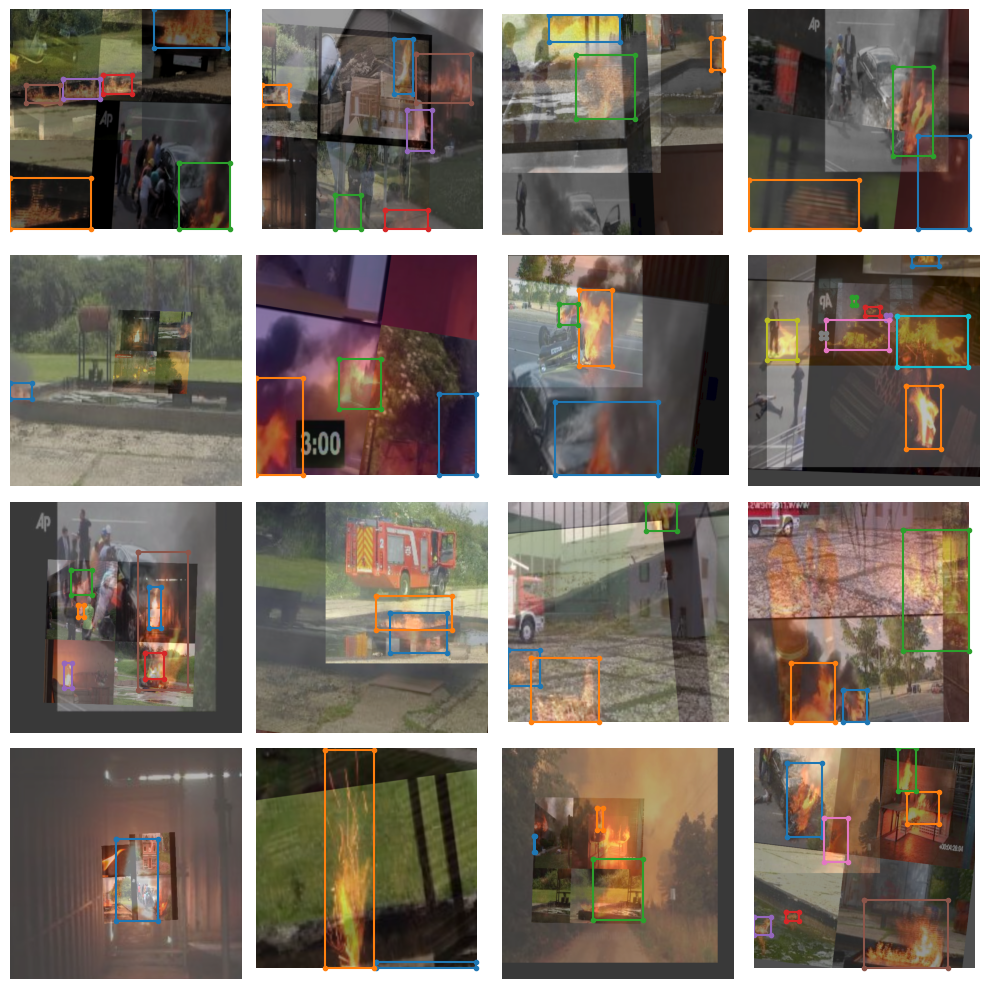

In [8]:
train_dataloader.dataset.plot()

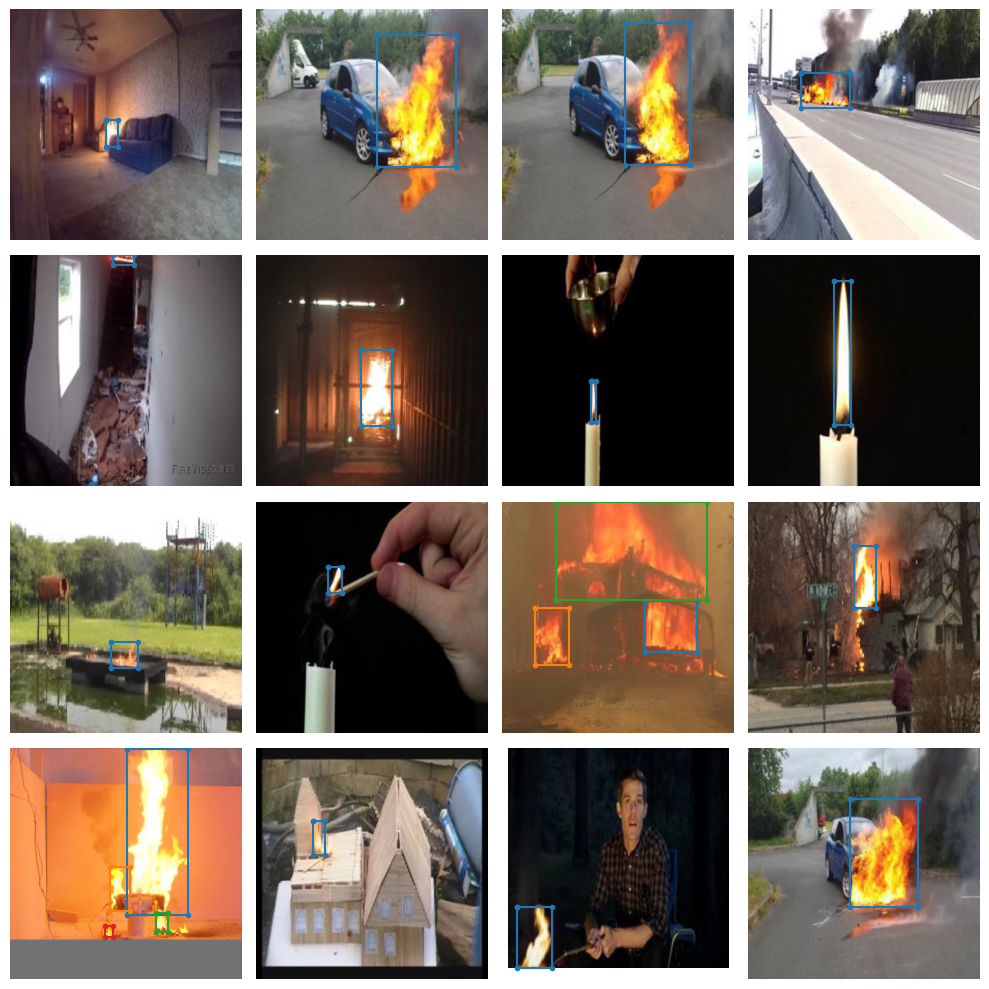

In [9]:
valid_dataloader.dataset.plot()

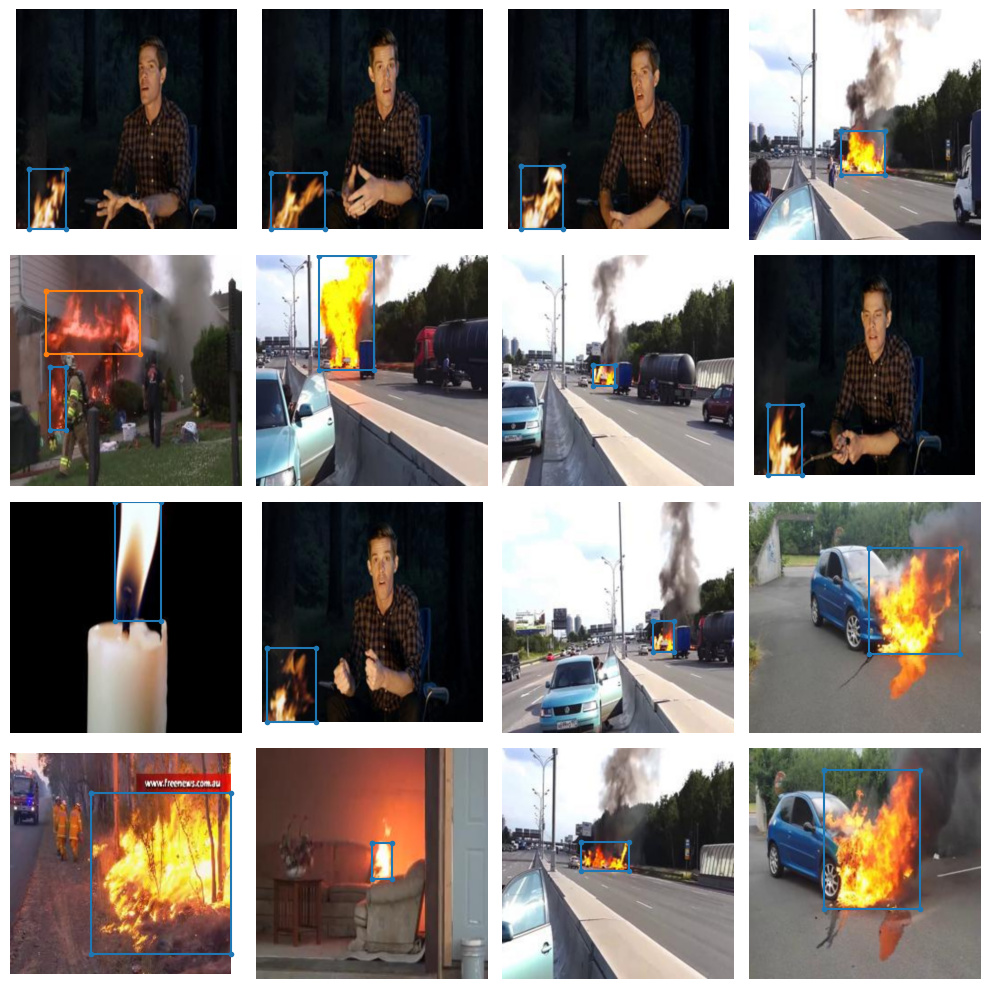

In [10]:
test_dataloader.dataset.plot()

## 💪 Fine-tuning YOLO Nas model on Bone-Fracture detection dataset

Now, since we have prepared our data and its ready to be feed into the model for training and evaluation

Let's prepare our model

1. Get `yolo_nas_m` model from super_gradients and set the num_classes to 4 (we working with 4 classes)
2. Build a Dictionary of Hyperparameters required while training
3. Define a Trainer object that can train the model and make checkpoints of the model's weights
4. Train your model
5. Get the best weights of the model during training and use it to evaluate on the Test dataset


In [11]:
from super_gradients.training import models

model = models.get('yolo_nas_m',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights='coco')

[2024-01-14 10:37:08] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_m_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_m_coco.pth
100%|██████████| 196M/196M [00:00<00:00, 271MB/s]
[2024-01-14 10:37:10] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_m


In [12]:
# Put model to target device = cuda
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(f'Model is on deivice: {next(model.parameters()).device}')

In [13]:
!pip install torchinfo
from torchinfo import summary

# Get summary of our model
summary(model=model,
        input_size=(16, 3, 640, 640),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Model is on deivice: cuda:0


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNAS_M (YoloNAS_M)                                             [16, 3, 640, 640]    [16, 8400, 4]        --                   True
├─NStageBackbone (backbone)                                       [16, 3, 640, 640]    [16, 96, 160, 160]   --                   True
│    └─YoloNASStem (stem)                                         [16, 3, 640, 640]    [16, 48, 320, 320]   --                   True
│    │    └─QARepVGGBlock (conv)                                  [16, 3, 640, 640]    [16, 48, 320, 320]   3,024                True
│    └─YoloNASStage (stage1)                                      [16, 48, 320, 320]   [16, 96, 160, 160]   --                   True
│    │    └─QARepVGGBlock (downsample)                            [16, 48, 320, 320]   [16, 96, 160, 160]   88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

### Trainable Parameters Dictionary


In [14]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 100 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 20,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [15]:
# Make a trainer object
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='YOLO_NAS_M', ckpt_root_dir=CHECKPOINT_DIR)

# Training model
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_dataloader,
              valid_loader=valid_dataloader)

[2024-01-14 10:37:17] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240114_103717_842246`
[2024-01-14 10:37:17] INFO - sg_trainer.py - Checkpoints directory: checkpoints/YOLO_NAS_M/RUN_20240114_103717_842246
[2024-01-14 10:37:17] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/YOLO_NAS_M/RUN_20240114_103717_842246/console_Jan14_10_37_17.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/optimizer_utils.py:107: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
[2024-01-14 10:37:22] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.3124
│   ├── Ppyoloeloss/loss_iou = 0.7099
│   ├── Ppyoloeloss/loss_dfl = 0.7647
│   └── Ppyoloeloss/loss = 3.787
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.5153
    ├── Ppyoloeloss/loss_iou = 0.4939
    ├── Ppyoloeloss/loss_dfl = 0.6358
    ├── Ppyoloeloss/loss = 3.645
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0612
    └── F1@0.50 = 0.0



Validating epoch 1: 100%|██████████| 47/47 [00:25<00:00,  1.86it/s]
[2024-01-14 10:41:07] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/YOLO_NAS_M/RUN_20240114_103717_842246/ckpt_best.pth
[2024-01-14 10:41:07] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.49606773257255554


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2414
│   │   ├── Epoch N-1      = 2.3124 (↘ -1.071)
│   │   └── Best until now = 2.3124 (↘ -1.071)
│   ├── Ppyoloeloss/loss_iou = 0.5679
│   │   ├── Epoch N-1      = 0.7099 (↘ -0.142)
│   │   └── Best until now = 0.7099 (↘ -0.142)
│   ├── Ppyoloeloss/loss_dfl = 0.6492
│   │   ├── Epoch N-1      = 0.7647 (↘ -0.1156)
│   │   └── Best until now = 0.7647 (↘ -0.1156)
│   └── Ppyoloeloss/loss = 2.4584
│       ├── Epoch N-1      = 3.787  (↘ -1.3286)
│       └── Best until now = 3.787  (↘ -1.3286)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.4105
    │   ├── Epoch N-1      = 2.5153 (↘ -0.1047)
    │   └── Best until now = 2.5153 (↘ -0.1047)
    ├── Ppyoloeloss/loss_iou = 0.4354
    │   ├── Epoch N-1      = 0.4939 (↘ -0.0585)
    │   └── Best until now = 0.4939 (↘ -0.0585)
    ├── Ppyoloeloss/loss_dfl = 0.5505
    │   ├── Epoch N-1      = 0.6358 (↘ -0.0853)
    │   └── Best until now = 0.6358 (↘ -0.0853)
    ├── Ppyoloeloss/loss =

Validating epoch 2: 100%|██████████| 47/47 [00:25<00:00,  1.87it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1114
│   │   ├── Epoch N-1      = 1.2414 (↘ -0.13)
│   │   └── Best until now = 1.2414 (↘ -0.13)
│   ├── Ppyoloeloss/loss_iou = 0.5526
│   │   ├── Epoch N-1      = 0.5679 (↘ -0.0153)
│   │   └── Best until now = 0.5679 (↘ -0.0153)
│   ├── Ppyoloeloss/loss_dfl = 0.6411
│   │   ├── Epoch N-1      = 0.6492 (↘ -0.0081)
│   │   └── Best until now = 0.6492 (↘ -0.0081)
│   └── Ppyoloeloss/loss = 2.3051
│       ├── Epoch N-1      = 2.4584 (↘ -0.1534)
│       └── Best until now = 2.4584 (↘ -0.1534)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4596
    │   ├── Epoch N-1      = 2.4105 (↘ -0.951)
    │   └── Best until now = 2.4105 (↘ -0.951)
    ├── Ppyoloeloss/loss_iou = 0.4727
    │   ├── Epoch N-1      = 0.4354 (↗ 0.0373)
    │   └── Best until now = 0.4354 (↗ 0.0373)
    ├── Ppyoloeloss/loss_dfl = 0.6522
    │   ├── Epoch N-1      = 0.5505 (↗ 0.1017)
    │   └── Best until now = 0.5505 (↗ 0.1017)
    ├── Ppyoloeloss/loss = 2.584

Validating epoch 3: 100%|██████████| 47/47 [00:25<00:00,  1.87it/s]
[2024-01-14 10:44:33] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/YOLO_NAS_M/RUN_20240114_103717_842246/ckpt_best.pth
[2024-01-14 10:44:33] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.4980598986148834


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1005
│   │   ├── Epoch N-1      = 1.1114 (↘ -0.0109)
│   │   └── Best until now = 1.1114 (↘ -0.0109)
│   ├── Ppyoloeloss/loss_iou = 0.5708
│   │   ├── Epoch N-1      = 0.5526 (↗ 0.0182)
│   │   └── Best until now = 0.5526 (↗ 0.0182)
│   ├── Ppyoloeloss/loss_dfl = 0.6701
│   │   ├── Epoch N-1      = 0.6411 (↗ 0.029)
│   │   └── Best until now = 0.6411 (↗ 0.029)
│   └── Ppyoloeloss/loss = 2.3414
│       ├── Epoch N-1      = 2.3051 (↗ 0.0363)
│       └── Best until now = 2.3051 (↗ 0.0363)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.8401
    │   ├── Epoch N-1      = 1.4596 (↗ 0.3806)
    │   └── Best until now = 1.4596 (↗ 0.3806)
    ├── Ppyoloeloss/loss_iou = 0.4637
    │   ├── Epoch N-1      = 0.4727 (↘ -0.009)
    │   └── Best until now = 0.4354 (↗ 0.0283)
    ├── Ppyoloeloss/loss_dfl = 0.6403
    │   ├── Epoch N-1      = 0.6522 (↘ -0.0119)
    │   └── Best until now = 0.5505 (↗ 0.0897)
    ├── Ppyoloeloss/loss = 2.9441
 

Validating epoch 4: 100%|██████████| 47/47 [00:25<00:00,  1.88it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0587
│   │   ├── Epoch N-1      = 1.1005 (↘ -0.0417)
│   │   └── Best until now = 1.1005 (↘ -0.0417)
│   ├── Ppyoloeloss/loss_iou = 0.5513
│   │   ├── Epoch N-1      = 0.5708 (↘ -0.0195)
│   │   └── Best until now = 0.5526 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.6442
│   │   ├── Epoch N-1      = 0.6701 (↘ -0.0259)
│   │   └── Best until now = 0.6411 (↗ 0.0031)
│   └── Ppyoloeloss/loss = 2.2542
│       ├── Epoch N-1      = 2.3414 (↘ -0.0872)
│       └── Best until now = 2.3051 (↘ -0.0509)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6292
    │   ├── Epoch N-1      = 1.8401 (↘ -0.211)
    │   └── Best until now = 1.4596 (↗ 0.1696)
    ├── Ppyoloeloss/loss_iou = 0.4703
    │   ├── Epoch N-1      = 0.4637 (↗ 0.0066)
    │   └── Best until now = 0.4354 (↗ 0.0349)
    ├── Ppyoloeloss/loss_dfl = 0.6214
    │   ├── Epoch N-1      = 0.6403 (↘ -0.0188)
    │   └── Best until now = 0.5505 (↗ 0.0709)
    ├── Ppyoloeloss/loss = 2

Validating epoch 5: 100%|██████████| 47/47 [00:24<00:00,  1.88it/s]
[2024-01-14 10:48:20] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/YOLO_NAS_M/RUN_20240114_103717_842246/ckpt_best.pth
[2024-01-14 10:48:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6485098004341125


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0501
│   │   ├── Epoch N-1      = 1.0587 (↘ -0.0087)
│   │   └── Best until now = 1.0587 (↘ -0.0087)
│   ├── Ppyoloeloss/loss_iou = 0.5443
│   │   ├── Epoch N-1      = 0.5513 (↘ -0.007)
│   │   └── Best until now = 0.5513 (↘ -0.007)
│   ├── Ppyoloeloss/loss_dfl = 0.6344
│   │   ├── Epoch N-1      = 0.6442 (↘ -0.0098)
│   │   └── Best until now = 0.6411 (↘ -0.0067)
│   └── Ppyoloeloss/loss = 2.2288
│       ├── Epoch N-1      = 2.2542 (↘ -0.0254)
│       └── Best until now = 2.2542 (↘ -0.0254)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1284
    │   ├── Epoch N-1      = 1.6292 (↘ -0.5008)
    │   └── Best until now = 1.4596 (↘ -0.3312)
    ├── Ppyoloeloss/loss_iou = 0.4115
    │   ├── Epoch N-1      = 0.4703 (↘ -0.0589)
    │   └── Best until now = 0.4354 (↘ -0.0239)
    ├── Ppyoloeloss/loss_dfl = 0.5466
    │   ├── Epoch N-1      = 0.6214 (↘ -0.0748)
    │   └── Best until now = 0.5505 (↘ -0.0039)
    ├── Ppyoloeloss/loss

Validating epoch 6: 100%|██████████| 47/47 [00:25<00:00,  1.87it/s]
[2024-01-14 10:50:05] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/YOLO_NAS_M/RUN_20240114_103717_842246/ckpt_best.pth
[2024-01-14 10:50:05] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6879099607467651


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0267
│   │   ├── Epoch N-1      = 1.0501 (↘ -0.0234)
│   │   └── Best until now = 1.0501 (↘ -0.0234)
│   ├── Ppyoloeloss/loss_iou = 0.5177
│   │   ├── Epoch N-1      = 0.5443 (↘ -0.0266)
│   │   └── Best until now = 0.5443 (↘ -0.0266)
│   ├── Ppyoloeloss/loss_dfl = 0.6073
│   │   ├── Epoch N-1      = 0.6344 (↘ -0.0271)
│   │   └── Best until now = 0.6344 (↘ -0.0271)
│   └── Ppyoloeloss/loss = 2.1516
│       ├── Epoch N-1      = 2.2288 (↘ -0.0771)
│       └── Best until now = 2.2288 (↘ -0.0771)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2888
    │   ├── Epoch N-1      = 1.1284 (↗ 0.1604)
    │   └── Best until now = 1.1284 (↗ 0.1604)
    ├── Ppyoloeloss/loss_iou = 0.4287
    │   ├── Epoch N-1      = 0.4115 (↗ 0.0172)
    │   └── Best until now = 0.4115 (↗ 0.0172)
    ├── Ppyoloeloss/loss_dfl = 0.5602
    │   ├── Epoch N-1      = 0.5466 (↗ 0.0136)
    │   └── Best until now = 0.5466 (↗ 0.0136)
    ├── Ppyoloeloss/loss = 2

Validating epoch 7: 100%|██████████| 47/47 [00:25<00:00,  1.84it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0136
│   │   ├── Epoch N-1      = 1.0267 (↘ -0.013)
│   │   └── Best until now = 1.0267 (↘ -0.013)
│   ├── Ppyoloeloss/loss_iou = 0.5156
│   │   ├── Epoch N-1      = 0.5177 (↘ -0.0021)
│   │   └── Best until now = 0.5177 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.6129
│   │   ├── Epoch N-1      = 0.6073 (↗ 0.0056)
│   │   └── Best until now = 0.6073 (↗ 0.0056)
│   └── Ppyoloeloss/loss = 2.1421
│       ├── Epoch N-1      = 2.1516 (↘ -0.0095)
│       └── Best until now = 2.1516 (↘ -0.0095)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1498
    │   ├── Epoch N-1      = 1.2888 (↘ -0.1391)
    │   └── Best until now = 1.1284 (↗ 0.0214)
    ├── Ppyoloeloss/loss_iou = 0.4192
    │   ├── Epoch N-1      = 0.4287 (↘ -0.0095)
    │   └── Best until now = 0.4115 (↗ 0.0077)
    ├── Ppyoloeloss/loss_dfl = 0.5442
    │   ├── Epoch N-1      = 0.5602 (↘ -0.016)
    │   └── Best until now = 0.5466 (↘ -0.0024)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 8: 100%|██████████| 47/47 [00:25<00:00,  1.88it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0065
│   │   ├── Epoch N-1      = 1.0136 (↘ -0.0071)
│   │   └── Best until now = 1.0136 (↘ -0.0071)
│   ├── Ppyoloeloss/loss_iou = 0.515
│   │   ├── Epoch N-1      = 0.5156 (↘ -0.0006)
│   │   └── Best until now = 0.5156 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.6065
│   │   ├── Epoch N-1      = 0.6129 (↘ -0.0063)
│   │   └── Best until now = 0.6073 (↘ -0.0007)
│   └── Ppyoloeloss/loss = 2.1281
│       ├── Epoch N-1      = 2.1421 (↘ -0.014)
│       └── Best until now = 2.1421 (↘ -0.014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2285
    │   ├── Epoch N-1      = 1.1498 (↗ 0.0787)
    │   └── Best until now = 1.1284 (↗ 0.1001)
    ├── Ppyoloeloss/loss_iou = 0.4319
    │   ├── Epoch N-1      = 0.4192 (↗ 0.0127)
    │   └── Best until now = 0.4115 (↗ 0.0204)
    ├── Ppyoloeloss/loss_dfl = 0.5637
    │   ├── Epoch N-1      = 0.5442 (↗ 0.0195)
    │   └── Best until now = 0.5442 (↗ 0.0195)
    ├── Ppyoloeloss/loss = 2.22

Validating epoch 9: 100%|██████████| 47/47 [00:25<00:00,  1.85it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.982
│   │   ├── Epoch N-1      = 1.0065 (↘ -0.0245)
│   │   └── Best until now = 1.0065 (↘ -0.0245)
│   ├── Ppyoloeloss/loss_iou = 0.4977
│   │   ├── Epoch N-1      = 0.515  (↘ -0.0173)
│   │   └── Best until now = 0.515  (↘ -0.0173)
│   ├── Ppyoloeloss/loss_dfl = 0.5859
│   │   ├── Epoch N-1      = 0.6065 (↘ -0.0207)
│   │   └── Best until now = 0.6065 (↘ -0.0207)
│   └── Ppyoloeloss/loss = 2.0655
│       ├── Epoch N-1      = 2.1281 (↘ -0.0625)
│       └── Best until now = 2.1281 (↘ -0.0625)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0511
    │   ├── Epoch N-1      = 1.2285 (↘ -0.1774)
    │   └── Best until now = 1.1284 (↘ -0.0773)
    ├── Ppyoloeloss/loss_iou = 0.4093
    │   ├── Epoch N-1      = 0.4319 (↘ -0.0226)
    │   └── Best until now = 0.4115 (↘ -0.0022)
    ├── Ppyoloeloss/loss_dfl = 0.5295
    │   ├── Epoch N-1      = 0.5637 (↘ -0.0343)
    │   └── Best until now = 0.5442 (↘ -0.0147)
    ├── Ppyoloeloss/los

Validating epoch 10: 100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9755
│   │   ├── Epoch N-1      = 0.982  (↘ -0.0065)
│   │   └── Best until now = 0.982  (↘ -0.0065)
│   ├── Ppyoloeloss/loss_iou = 0.4971
│   │   ├── Epoch N-1      = 0.4977 (↘ -0.0006)
│   │   └── Best until now = 0.4977 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.5848
│   │   ├── Epoch N-1      = 0.5859 (↘ -0.0011)
│   │   └── Best until now = 0.5859 (↘ -0.0011)
│   └── Ppyoloeloss/loss = 2.0573
│       ├── Epoch N-1      = 2.0655 (↘ -0.0082)
│       └── Best until now = 2.0655 (↘ -0.0082)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0909
    │   ├── Epoch N-1      = 1.0511 (↗ 0.0398)
    │   └── Best until now = 1.0511 (↗ 0.0398)
    ├── Ppyoloeloss/loss_iou = 0.4108
    │   ├── Epoch N-1      = 0.4093 (↗ 0.0015)
    │   └── Best until now = 0.4093 (↗ 0.0015)
    ├── Ppyoloeloss/loss_dfl = 0.5283
    │   ├── Epoch N-1      = 0.5295 (↘ -0.0011)
    │   └── Best until now = 0.5295 (↘ -0.0011)
    ├── Ppyoloeloss/loss 

Validating epoch 11: 100%|██████████| 47/47 [00:25<00:00,  1.86it/s]
[2024-01-14 10:59:35] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/YOLO_NAS_M/RUN_20240114_103717_842246/ckpt_best.pth
[2024-01-14 10:59:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7012266516685486


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.962
│   │   ├── Epoch N-1      = 0.9755 (↘ -0.0134)
│   │   └── Best until now = 0.9755 (↘ -0.0134)
│   ├── Ppyoloeloss/loss_iou = 0.4896
│   │   ├── Epoch N-1      = 0.4971 (↘ -0.0075)
│   │   └── Best until now = 0.4971 (↘ -0.0075)
│   ├── Ppyoloeloss/loss_dfl = 0.5769
│   │   ├── Epoch N-1      = 0.5848 (↘ -0.0079)
│   │   └── Best until now = 0.5848 (↘ -0.0079)
│   └── Ppyoloeloss/loss = 2.0285
│       ├── Epoch N-1      = 2.0573 (↘ -0.0288)
│       └── Best until now = 2.0573 (↘ -0.0288)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0088
    │   ├── Epoch N-1      = 1.0909 (↘ -0.0821)
    │   └── Best until now = 1.0511 (↘ -0.0423)
    ├── Ppyoloeloss/loss_iou = 0.4128
    │   ├── Epoch N-1      = 0.4108 (↗ 0.002)
    │   └── Best until now = 0.4093 (↗ 0.0035)
    ├── Ppyoloeloss/loss_dfl = 0.5395
    │   ├── Epoch N-1      = 0.5283 (↗ 0.0112)
    │   └── Best until now = 0.5283 (↗ 0.0112)
    ├── Ppyoloeloss/loss = 

Validating epoch 12: 100%|██████████| 47/47 [00:25<00:00,  1.85it/s]
[2024-01-14 11:01:45] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/YOLO_NAS_M/RUN_20240114_103717_842246/ckpt_best.pth
[2024-01-14 11:01:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7385067939758301


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9407
│   │   ├── Epoch N-1      = 0.962  (↘ -0.0213)
│   │   └── Best until now = 0.962  (↘ -0.0213)
│   ├── Ppyoloeloss/loss_iou = 0.4721
│   │   ├── Epoch N-1      = 0.4896 (↘ -0.0175)
│   │   └── Best until now = 0.4896 (↘ -0.0175)
│   ├── Ppyoloeloss/loss_dfl = 0.5587
│   │   ├── Epoch N-1      = 0.5769 (↘ -0.0182)
│   │   └── Best until now = 0.5769 (↘ -0.0182)
│   └── Ppyoloeloss/loss = 1.9715
│       ├── Epoch N-1      = 2.0285 (↘ -0.057)
│       └── Best until now = 2.0285 (↘ -0.057)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9501
    │   ├── Epoch N-1      = 1.0088 (↘ -0.0587)
    │   └── Best until now = 1.0088 (↘ -0.0587)
    ├── Ppyoloeloss/loss_iou = 0.3957
    │   ├── Epoch N-1      = 0.4128 (↘ -0.0171)
    │   └── Best until now = 0.4093 (↘ -0.0136)
    ├── Ppyoloeloss/loss_dfl = 0.5101
    │   ├── Epoch N-1      = 0.5395 (↘ -0.0294)
    │   └── Best until now = 0.5283 (↘ -0.0182)
    ├── Ppyoloeloss/los

Validating epoch 13: 100%|██████████| 47/47 [00:25<00:00,  1.84it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9415
│   │   ├── Epoch N-1      = 0.9407 (↗ 0.0008)
│   │   └── Best until now = 0.9407 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_iou = 0.4737
│   │   ├── Epoch N-1      = 0.4721 (↗ 0.0016)
│   │   └── Best until now = 0.4721 (↗ 0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.5608
│   │   ├── Epoch N-1      = 0.5587 (↗ 0.0021)
│   │   └── Best until now = 0.5587 (↗ 0.0021)
│   └── Ppyoloeloss/loss = 1.976
│       ├── Epoch N-1      = 1.9715 (↗ 0.0045)
│       └── Best until now = 1.9715 (↗ 0.0045)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9519
    │   ├── Epoch N-1      = 0.9501 (↗ 0.0018)
    │   └── Best until now = 0.9501 (↗ 0.0018)
    ├── Ppyoloeloss/loss_iou = 0.3934
    │   ├── Epoch N-1      = 0.3957 (↘ -0.0023)
    │   └── Best until now = 0.3957 (↘ -0.0023)
    ├── Ppyoloeloss/loss_dfl = 0.5056
    │   ├── Epoch N-1      = 0.5101 (↘ -0.0046)
    │   └── Best until now = 0.5101 (↘ -0.0046)
    ├── Ppyoloeloss/loss = 1.850

Validating epoch 14: 100%|██████████| 47/47 [00:25<00:00,  1.86it/s]
[2024-01-14 11:05:44] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/YOLO_NAS_M/RUN_20240114_103717_842246/ckpt_best.pth
[2024-01-14 11:05:44] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7810117602348328


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9205
│   │   ├── Epoch N-1      = 0.9415 (↘ -0.021)
│   │   └── Best until now = 0.9407 (↘ -0.0202)
│   ├── Ppyoloeloss/loss_iou = 0.4651
│   │   ├── Epoch N-1      = 0.4737 (↘ -0.0086)
│   │   └── Best until now = 0.4721 (↘ -0.007)
│   ├── Ppyoloeloss/loss_dfl = 0.5554
│   │   ├── Epoch N-1      = 0.5608 (↘ -0.0054)
│   │   └── Best until now = 0.5587 (↘ -0.0033)
│   └── Ppyoloeloss/loss = 1.941
│       ├── Epoch N-1      = 1.976  (↘ -0.035)
│       └── Best until now = 1.9715 (↘ -0.0305)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9126
    │   ├── Epoch N-1      = 0.9519 (↘ -0.0392)
    │   └── Best until now = 0.9501 (↘ -0.0375)
    ├── Ppyoloeloss/loss_iou = 0.415
    │   ├── Epoch N-1      = 0.3934 (↗ 0.0216)
    │   └── Best until now = 0.3934 (↗ 0.0216)
    ├── Ppyoloeloss/loss_dfl = 0.522
    │   ├── Epoch N-1      = 0.5056 (↗ 0.0165)
    │   └── Best until now = 0.5056 (↗ 0.0165)
    ├── Ppyoloeloss/loss = 1.84

Validating epoch 15: 100%|██████████| 47/47 [00:25<00:00,  1.87it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9133
│   │   ├── Epoch N-1      = 0.9205 (↘ -0.0073)
│   │   └── Best until now = 0.9205 (↘ -0.0073)
│   ├── Ppyoloeloss/loss_iou = 0.4596
│   │   ├── Epoch N-1      = 0.4651 (↘ -0.0055)
│   │   └── Best until now = 0.4651 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_dfl = 0.5528
│   │   ├── Epoch N-1      = 0.5554 (↘ -0.0026)
│   │   └── Best until now = 0.5554 (↘ -0.0026)
│   └── Ppyoloeloss/loss = 1.9257
│       ├── Epoch N-1      = 1.941  (↘ -0.0153)
│       └── Best until now = 1.941  (↘ -0.0153)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9277
    │   ├── Epoch N-1      = 0.9126 (↗ 0.015)
    │   └── Best until now = 0.9126 (↗ 0.015)
    ├── Ppyoloeloss/loss_iou = 0.3918
    │   ├── Epoch N-1      = 0.415  (↘ -0.0232)
    │   └── Best until now = 0.3934 (↘ -0.0016)
    ├── Ppyoloeloss/loss_dfl = 0.5023
    │   ├── Epoch N-1      = 0.522  (↘ -0.0198)
    │   └── Best until now = 0.5056 (↘ -0.0033)
    ├── Ppyoloeloss/loss 

Validating epoch 16: 100%|██████████| 47/47 [00:25<00:00,  1.87it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8874
│   │   ├── Epoch N-1      = 0.9133 (↘ -0.0258)
│   │   └── Best until now = 0.9133 (↘ -0.0258)
│   ├── Ppyoloeloss/loss_iou = 0.4458
│   │   ├── Epoch N-1      = 0.4596 (↘ -0.0138)
│   │   └── Best until now = 0.4596 (↘ -0.0138)
│   ├── Ppyoloeloss/loss_dfl = 0.5394
│   │   ├── Epoch N-1      = 0.5528 (↘ -0.0134)
│   │   └── Best until now = 0.5528 (↘ -0.0134)
│   └── Ppyoloeloss/loss = 1.8726
│       ├── Epoch N-1      = 1.9257 (↘ -0.0531)
│       └── Best until now = 1.9257 (↘ -0.0531)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9558
    │   ├── Epoch N-1      = 0.9277 (↗ 0.0281)
    │   └── Best until now = 0.9126 (↗ 0.0431)
    ├── Ppyoloeloss/loss_iou = 0.4071
    │   ├── Epoch N-1      = 0.3918 (↗ 0.0153)
    │   └── Best until now = 0.3918 (↗ 0.0153)
    ├── Ppyoloeloss/loss_dfl = 0.5219
    │   ├── Epoch N-1      = 0.5023 (↗ 0.0196)
    │   └── Best until now = 0.5023 (↗ 0.0196)
    ├── Ppyoloeloss/loss = 

Validating epoch 17: 100%|██████████| 47/47 [00:25<00:00,  1.85it/s]
[2024-01-14 11:12:26] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/YOLO_NAS_M/RUN_20240114_103717_842246/ckpt_best.pth
[2024-01-14 11:12:26] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8036536574363708


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8715
│   │   ├── Epoch N-1      = 0.8874 (↘ -0.0159)
│   │   └── Best until now = 0.8874 (↘ -0.0159)
│   ├── Ppyoloeloss/loss_iou = 0.4438
│   │   ├── Epoch N-1      = 0.4458 (↘ -0.002)
│   │   └── Best until now = 0.4458 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.5345
│   │   ├── Epoch N-1      = 0.5394 (↘ -0.0049)
│   │   └── Best until now = 0.5394 (↘ -0.0049)
│   └── Ppyoloeloss/loss = 1.8498
│       ├── Epoch N-1      = 1.8726 (↘ -0.0228)
│       └── Best until now = 1.8726 (↘ -0.0228)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9272
    │   ├── Epoch N-1      = 0.9558 (↘ -0.0285)
    │   └── Best until now = 0.9126 (↗ 0.0146)
    ├── Ppyoloeloss/loss_iou = 0.415
    │   ├── Epoch N-1      = 0.4071 (↗ 0.0079)
    │   └── Best until now = 0.3918 (↗ 0.0232)
    ├── Ppyoloeloss/loss_dfl = 0.5141
    │   ├── Epoch N-1      = 0.5219 (↘ -0.0078)
    │   └── Best until now = 0.5023 (↗ 0.0119)
    ├── Ppyoloeloss/loss = 1

Validating epoch 18: 100%|██████████| 47/47 [00:25<00:00,  1.84it/s]
[2024-01-14 11:14:41] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/YOLO_NAS_M/RUN_20240114_103717_842246/ckpt_best.pth
[2024-01-14 11:14:41] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.82221919298172


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8754
│   │   ├── Epoch N-1      = 0.8715 (↗ 0.0038)
│   │   └── Best until now = 0.8715 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_iou = 0.443
│   │   ├── Epoch N-1      = 0.4438 (↘ -0.0008)
│   │   └── Best until now = 0.4438 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.5374
│   │   ├── Epoch N-1      = 0.5345 (↗ 0.0029)
│   │   └── Best until now = 0.5345 (↗ 0.0029)
│   └── Ppyoloeloss/loss = 1.8558
│       ├── Epoch N-1      = 1.8498 (↗ 0.006)
│       └── Best until now = 1.8498 (↗ 0.006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8992
    │   ├── Epoch N-1      = 0.9272 (↘ -0.028)
    │   └── Best until now = 0.9126 (↘ -0.0134)
    ├── Ppyoloeloss/loss_iou = 0.421
    │   ├── Epoch N-1      = 0.415  (↗ 0.006)
    │   └── Best until now = 0.3918 (↗ 0.0292)
    ├── Ppyoloeloss/loss_dfl = 0.5173
    │   ├── Epoch N-1      = 0.5141 (↗ 0.0032)
    │   └── Best until now = 0.5023 (↗ 0.0151)
    ├── Ppyoloeloss/loss = 1.8376
   

Validating epoch 19: 100%|██████████| 47/47 [00:25<00:00,  1.86it/s]
[2024-01-14 11:16:46] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/YOLO_NAS_M/RUN_20240114_103717_842246/ckpt_best.pth
[2024-01-14 11:16:46] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.829678475856781


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8596
│   │   ├── Epoch N-1      = 0.8754 (↘ -0.0158)
│   │   └── Best until now = 0.8715 (↘ -0.012)
│   ├── Ppyoloeloss/loss_iou = 0.4352
│   │   ├── Epoch N-1      = 0.443  (↘ -0.0078)
│   │   └── Best until now = 0.443  (↘ -0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.5256
│   │   ├── Epoch N-1      = 0.5374 (↘ -0.0118)
│   │   └── Best until now = 0.5345 (↘ -0.0089)
│   └── Ppyoloeloss/loss = 1.8204
│       ├── Epoch N-1      = 1.8558 (↘ -0.0354)
│       └── Best until now = 1.8498 (↘ -0.0294)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9003
    │   ├── Epoch N-1      = 0.8992 (↗ 0.001)
    │   └── Best until now = 0.8992 (↗ 0.001)
    ├── Ppyoloeloss/loss_iou = 0.3837
    │   ├── Epoch N-1      = 0.421  (↘ -0.0373)
    │   └── Best until now = 0.3918 (↘ -0.0081)
    ├── Ppyoloeloss/loss_dfl = 0.491
    │   ├── Epoch N-1      = 0.5173 (↘ -0.0263)
    │   └── Best until now = 0.5023 (↘ -0.0113)
    ├── Ppyoloeloss/loss = 

[2024-01-14 11:17:26] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 20: 100%|██████████| 47/47 [00:25<00:00,  1.84it/s]


## Inference with best model weights during training on images from internet

[2024-01-14 11:28:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/visualization/utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("gist_rainbow", num_classes)


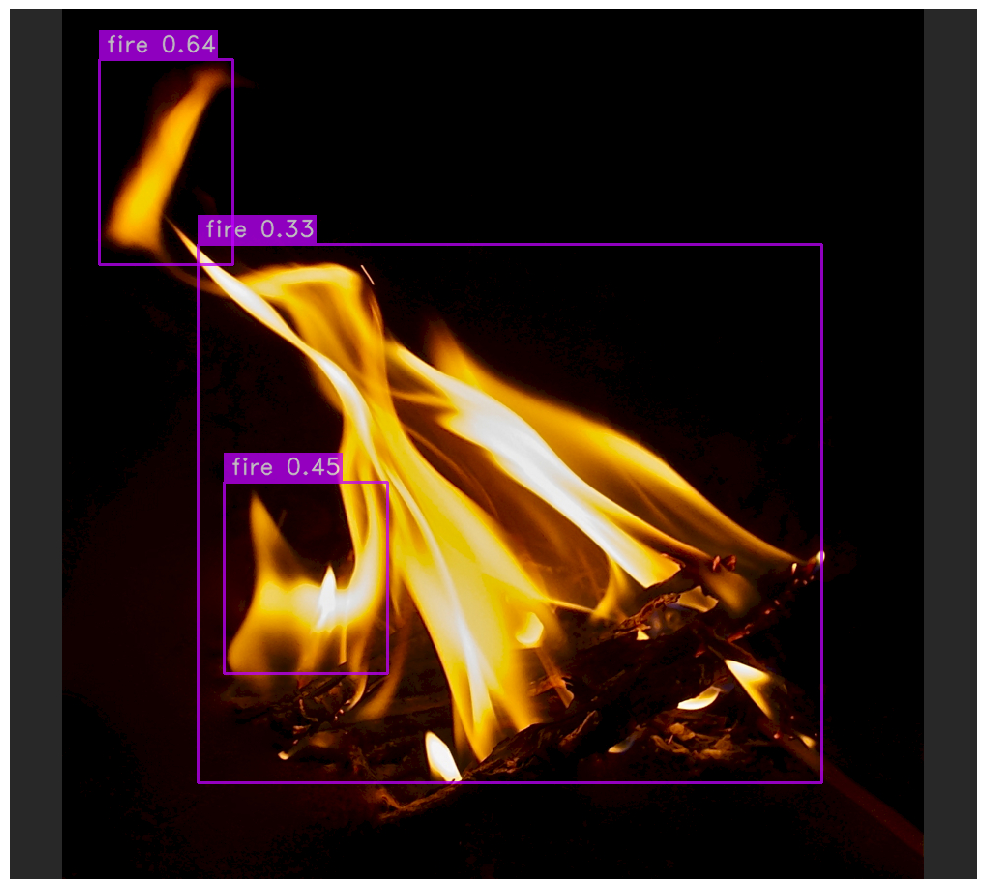

In [25]:
 model.predict('https://th.bing.com/th/id/R.24362bf711b0e620089eb9727521ae83?rik=vt3OjH0F7NtCgw&riu=http%3a%2f%2fwww.flowvis.org%2fwp-content%2fuploads%2f2017%2f12%2f2014TeamSecondBrian_Kazar.jpg&ehk=P5H%2fQDoId%2bbd9XkR1YYcArjVLheSV4uLmz8ZVsKDIJY%3d&risl=&pid=ImgRaw&r=0', conf=0.25).show()

[2024-01-14 11:28:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


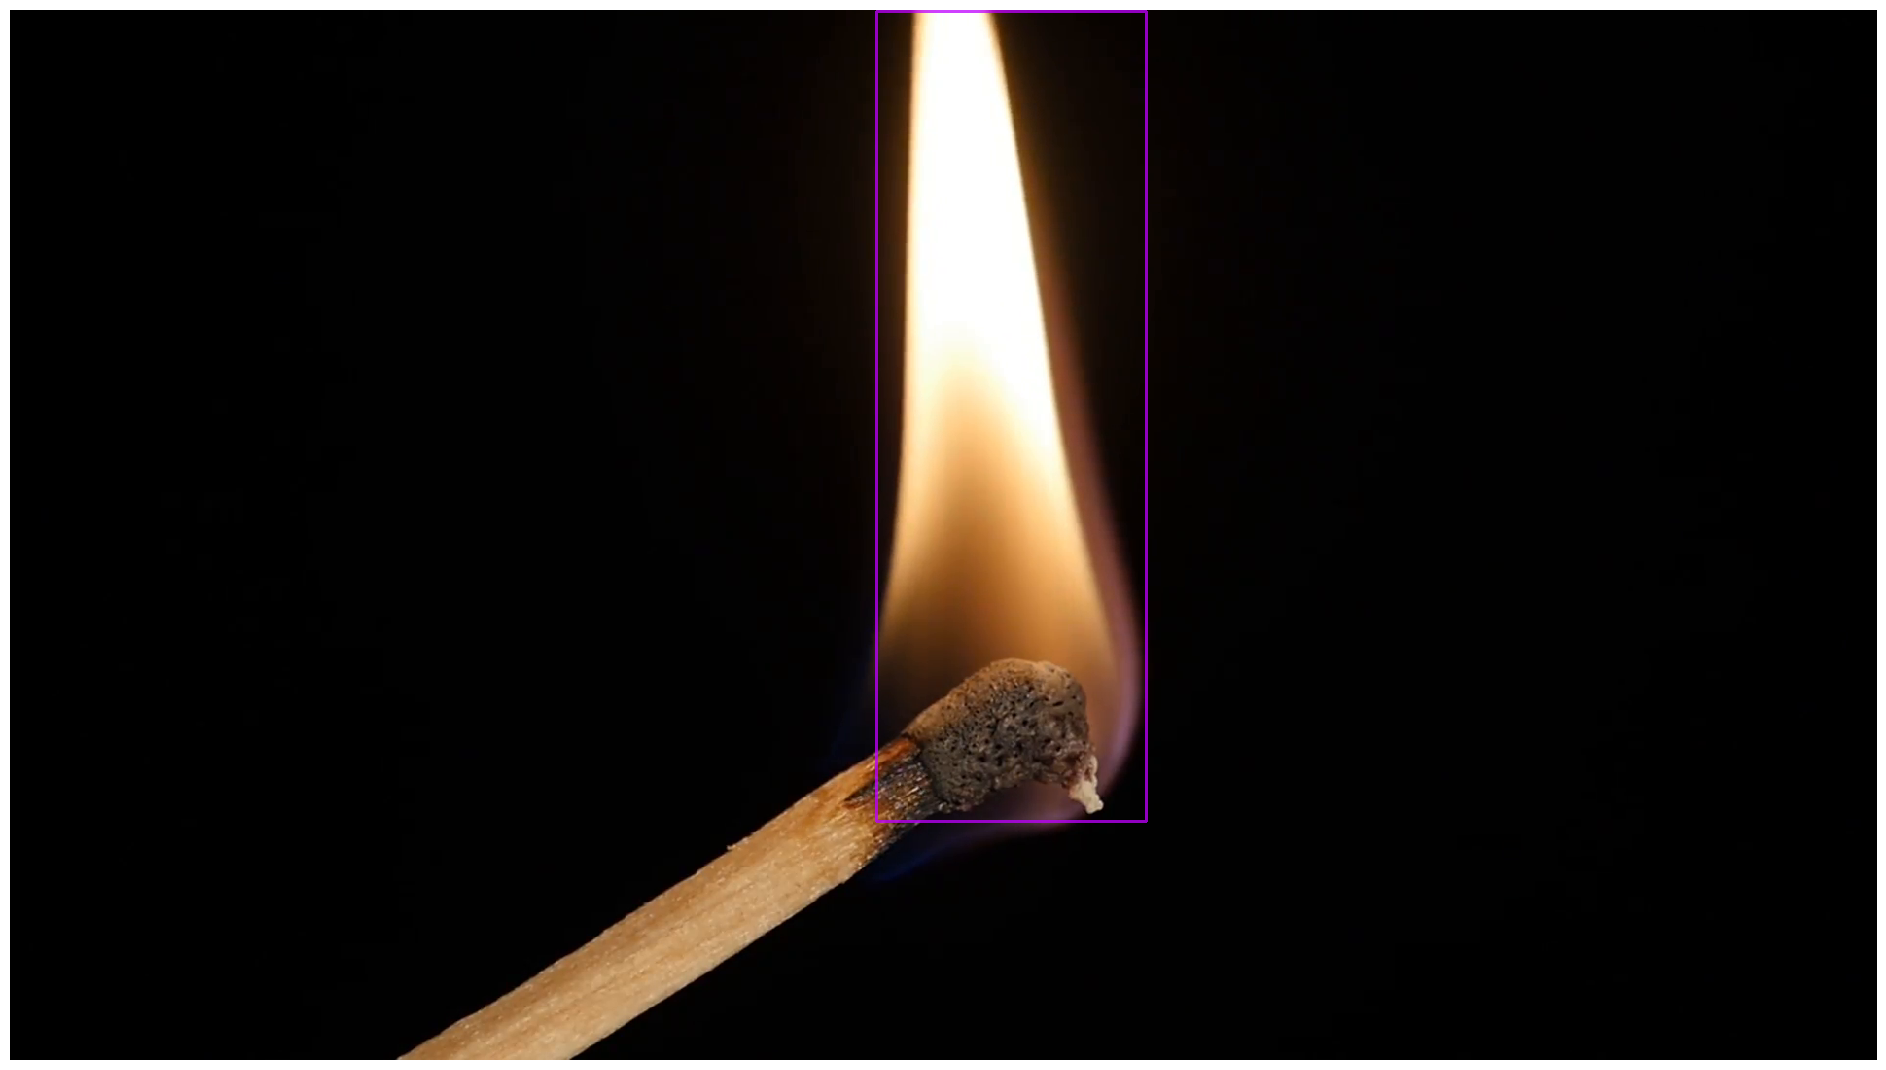

In [26]:
model.predict('https://jooinn.com/images/matchstick-2.png', conf=0.5).show()

[2024-01-14 11:28:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


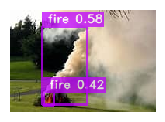

In [27]:
model.predict('https://th.bing.com/th?id=OSK.526fe3b2182e8c380d44437944e81828&w=188&h=132&c=7&o=6&pid=SANGAM', conf=0.4).show()

In [32]:
# Using videos
model.predict('/content/fire_video1.mp4').save('/content/fire_video1_detections.mp4')

Processing Video:  91%|█████████ | 393/432 [00:11<00:01, 35.79it/s]

In [34]:
# Using videos
model.predict('/content/fire_video2.mp4').save('/content/fire_video2_detections.mp4')

Processing Video: 100%|██████████| 257/257 [00:06<00:00, 40.53it/s]
